<a href="https://colab.research.google.com/github/hhprojects/AI-Projects/blob/main/cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SC3000 Assignment 1: Balancing a Pole on a Cart using Enhanced Q-Learning and Deep Q-Network

## Introduction
This notebook experiments with an enhanced Q-learning agent and Deep Q-Network to solve the CartPole balancing problem.

## Contributions

### Q-Learning Agent:
#### Han Hua
- Initializing Q-Learning Agent
- Training
- Task 1-3

### DQN Agent:
#### Zong Han
- Deep Q-Network
- ReplayBuffer
- DQN Agent

#### Zhi Xian
- Training
- Task 1-3


## Setup and Environment
First, import the necessary libraries.

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import time
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from gym.wrappers import RecordVideo
import os

### QLearningAgent

**Methods**:
- `__init__`: Initializes agent parameters and discretization bins
- `discretize_state`: Converts continuous state to discrete representation
- `select_action`: Chooses actions using epsilon-greedy with optimizations
- `update_q_value`: Updates Q-values using TD(λ) learning
- `calculate_reward`: Computes enhanced reward signal

In [ ]:
class QLearningAgent:
    def __init__(self, n_bins=30, learning_rate=0.1, discount_factor=0.99):
        self.n_bins = n_bins
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor

        # Define state bins for discretization with focus on critical regions
        # The cart position range is technically -4.8 to 4.8, but effective range is smaller
        self.cart_position_bins = np.linspace(-2.4, 2.4, n_bins)

        # Higher resolution near zero for better balance
        self.cart_velocity_bins = np.concatenate([
            np.linspace(-3.0, -0.5, n_bins//3),
            np.linspace(-0.5, 0.5, n_bins//3),
            np.linspace(0.5, 3.0, n_bins//3)
        ])

        # The pole angle range is -0.418 to 0.418 radians, but focus on smaller range
        self.pole_angle_bins = np.concatenate([
            np.linspace(-0.2095, -0.05, n_bins//3),
            np.linspace(-0.05, 0.05, n_bins//3),
            np.linspace(0.05, 0.2095, n_bins//3)
        ])

        # Higher resolution near zero for better control
        self.pole_velocity_bins = np.concatenate([
            np.linspace(-3.5, -0.5, n_bins//3),
            np.linspace(-0.5, 0.5, n_bins//3),
            np.linspace(0.5, 3.5, n_bins//3)
        ])

        # Initialize Q-table
        self.q_table = defaultdict(lambda: np.zeros(2))  # 2 actions for CartPole

        # Initialize eligibility traces for TD(λ)
        self.eligibility_traces = defaultdict(lambda: np.zeros(2))
        self.lambda_param = 0.9  # Eligibility trace decay parameter

    def discretize_state(self, state):
        cart_position, cart_velocity, pole_angle, pole_velocity = state

        # Discretize each dimension
        cart_pos_bin = np.digitize(cart_position, self.cart_position_bins)
        cart_vel_bin = np.digitize(cart_velocity, self.cart_velocity_bins)
        pole_angle_bin = np.digitize(pole_angle, self.pole_angle_bins)
        pole_vel_bin = np.digitize(pole_velocity, self.pole_velocity_bins)

        # Create discrete state tuple
        return (cart_pos_bin, cart_vel_bin, pole_angle_bin, pole_vel_bin)

    def select_action(self, state, exploration_rate):
        # Prioritize stability in critical states (when pole is almost upright and velocities are low)
        if np.random.random() < exploration_rate:
            # Special exploration for critical states
            _, _, pole_angle_bin, pole_vel_bin = state
            if (pole_angle_bin in range(self.n_bins//3, 2*self.n_bins//3) and
                pole_vel_bin in range(self.n_bins//3, 2*self.n_bins//3)):
                # In critical state, explore more intelligently based on current Q-values
                # Take random action with bias toward the better action
                q_values = self.q_table[state]
                probs = np.exp(q_values) / np.sum(np.exp(q_values))  # Softmax
                return np.random.choice([0, 1], p=probs)
            else:
                # Standard random exploration
                return np.random.choice([0, 1])
        else:
            # Exploit: select action with highest Q-value
            return np.argmax(self.q_table[state])

    def update_q_value(self, state, action, reward, next_state, done):
        # Maximum Q-value for next state
        max_future_q = np.max(self.q_table[next_state]) if not done else 0

        # Current Q-value
        current_q = self.q_table[state][action]

        # Calculate TD error
        td_error = reward + self.discount_factor * max_future_q - current_q

        # Update eligibility trace for current state-action pair
        self.eligibility_traces[state][action] = 1.0

        # Update all state-action pairs according to their eligibility
        for s in self.eligibility_traces:
            for a in range(2):  # 2 actions
                # Update Q-value
                self.q_table[s][a] += self.learning_rate * td_error * self.eligibility_traces[s][a]
                # Decay eligibility trace
                self.eligibility_traces[s][a] *= self.discount_factor * self.lambda_param

        # Reset traces if episode has ended
        if done:
            self.eligibility_traces = defaultdict(lambda: np.zeros(2))

    def calculate_reward(self, state, action, next_state, done, raw_reward):
        if done:
            # If episode ends early (failure), give large negative reward
            if raw_reward < 195:  # Not a successful episode
                return -100
            return raw_reward  # Otherwise, keep original reward

        # Extract state information
        _, _, pole_angle, pole_velocity = next_state

        # Reward for keeping the pole upright (smaller angle is better)
        angle_reward = 1.0 - abs(pole_angle) * 2  # Max reward when angle is zero

        # Penalty for high pole velocity (more stable is better)
        velocity_penalty = -abs(pole_velocity) * 0.1

        # Combine rewards
        return raw_reward + angle_reward + velocity_penalty

### Training Function
**Purpose**: Trains the Q-learning agent on the CartPole environment.

**Parameters**:
- `n_episodes`: Maximum number of training episodes (default: 3000)
- `render_every`: Optional parameter to render every N episodes

**Returns**:
- Trained agent instance
- List of raw rewards per episode
- List of average rewards over time

In [ ]:
def train_enhanced_agent(n_episodes=3000, render_every=None):
    env = gym.make('CartPole-v1')
    agent = QLearningAgent(n_bins=30)

    # Improved training parameters
    exploration_rate = 1.0
    min_exploration_rate = 0.01
    exploration_decay = 0.995  # Adjusted decay rate

    # For tracking performance
    rewards_per_episode = []
    raw_rewards_per_episode = []  # Track the environment's raw rewards
    avg_rewards = []

    # Experience replay buffer
    replay_buffer = []
    replay_buffer_size = 10000
    replay_batch_size = 32

    for episode in range(n_episodes):
        # Reset environment
        state = env.reset()[0]
        state_disc = agent.discretize_state(state)

        done = False
        truncated = False
        episode_reward = 0
        raw_episode_reward = 0
        episode_transitions = []  # Store transitions for this episode

        # Run episode
        while not (done or truncated):

            # Select action
            action = agent.select_action(state_disc, exploration_rate)

            # Take action
            next_state, raw_reward, done, truncated, _ = env.step(action)
            next_state_disc = agent.discretize_state(next_state)

            # Calculate enhanced reward
            reward = agent.calculate_reward(state, action, next_state, done, raw_reward)

            # Store transition
            episode_transitions.append((state_disc, action, reward, next_state_disc, done))

            # Update running reward totals
            episode_reward += reward
            raw_episode_reward += raw_reward

            # Update Q-table
            agent.update_q_value(state_disc, action, reward, next_state_disc, done)

            # Move to next state
            state = next_state
            state_disc = next_state_disc

        # Add episode transitions to replay buffer
        replay_buffer.extend(episode_transitions)
        if len(replay_buffer) > replay_buffer_size:
            replay_buffer = replay_buffer[-replay_buffer_size:]

        # Experience replay - randomly sample and learn from past experiences
        if len(replay_buffer) >= replay_batch_size:
            replay_indices = np.random.choice(len(replay_buffer), replay_batch_size, replace=False)
            for idx in replay_indices:
                s, a, r, next_s, d = replay_buffer[idx]
                agent.update_q_value(s, a, r, next_s, d)

        # Update exploration rate with adaptive decay
        if len(raw_rewards_per_episode) >= 100 and np.mean(raw_rewards_per_episode[-10:]) > 150:
            # If recent performance is good, decay faster to exploit more
            exploration_rate = max(min_exploration_rate, exploration_rate * 0.97)
        else:
            # Otherwise, decay slower to allow more exploration
            exploration_rate = max(min_exploration_rate, exploration_rate * exploration_decay)

        # Track performance
        rewards_per_episode.append(episode_reward)
        raw_rewards_per_episode.append(raw_episode_reward)
        avg_raw_reward = np.mean(raw_rewards_per_episode[-100:]) if len(raw_rewards_per_episode) >= 100 else np.mean(raw_rewards_per_episode)
        avg_rewards.append(avg_raw_reward)

        # Print progress
        if episode % 100 == 0:
            print(f"Episode {episode}, Raw Reward: {raw_episode_reward}, Avg Raw Reward (last 100): {avg_raw_reward:.2f}, Exploration Rate: {exploration_rate:.3f}")

        # Early stopping if solved with high confidence
        if len(raw_rewards_per_episode) >= 100 and avg_raw_reward >= 220:
            print(f"Environment solved in {episode} episodes! Average Reward: {avg_raw_reward:.2f}")
            if episode % 100 != 0:  # Only break if not already printed above
                break

    env.close()

    # Plot results
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 3)
    plt.plot(avg_rewards)
    plt.axhline(y=195, color='r', linestyle='--', label='Solved Threshold (195)')
    plt.axhline(y=240, color='g', linestyle='--', label='Excellent Performance (240)')
    plt.title('Average Raw Reward (Last 100 Episodes)')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.legend()

    plt.subplot(2, 2, 4)
    # Histogram of the last 100 raw rewards
    plt.hist(raw_rewards_per_episode[-100:], bins=20)
    plt.title('Distribution of Last 100 Episode Rewards')
    plt.xlabel('Reward')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.savefig('cartpole_qlearning_enhanced_results.png')
    plt.show()

    return agent, raw_rewards_per_episode, avg_rewards

## Task 1: Development of an RL agent

Demonstrating the correctness of implementation by sampling a random state from the cart pole environment, inputting to the agent, and outputting a chosen action.

### Training Function (train_enhanced_agent)
**Purpose**: Trains the Q-learning agent on the CartPole environment.
**Parameters**:
- `n_episodes`: Maximum training episodes (default: 3000)
- `render_every`: Optional parameter for visualization

**Returns**:
- Trained agent instance
- List of raw rewards per episode
- List of average rewards

## Task 1: Development of RL Agent
**Original Implementation Features:**
1. **Adaptive State Discretization**
   - Traditional Q-learning uses uniform discretization
   - Our improvement: Non-uniform bin distribution
   - Higher resolution near critical states (around 0° angle and velocity)
   - Benefits: Better control precision where it matters most

2. **Enhanced Exploration Strategy**
   - Traditional: Simple ε-greedy exploration
   - Our improvement: Intelligent exploration in critical states
   - Uses softmax probability for better action selection
   - Results in faster learning in important state regions

Training enhanced Q-learning agent for CartPole...
Episode 0, Raw Reward: 18.0, Avg Raw Reward (last 100): 18.00, Exploration Rate: 0.995
Episode 100, Raw Reward: 23.0, Avg Raw Reward (last 100): 40.42, Exploration Rate: 0.603
Episode 200, Raw Reward: 69.0, Avg Raw Reward (last 100): 69.35, Exploration Rate: 0.365
Episode 300, Raw Reward: 42.0, Avg Raw Reward (last 100): 84.75, Exploration Rate: 0.221
Episode 400, Raw Reward: 235.0, Avg Raw Reward (last 100): 99.98, Exploration Rate: 0.134
Episode 500, Raw Reward: 366.0, Avg Raw Reward (last 100): 124.32, Exploration Rate: 0.054
Episode 600, Raw Reward: 71.0, Avg Raw Reward (last 100): 132.50, Exploration Rate: 0.016
Episode 700, Raw Reward: 202.0, Avg Raw Reward (last 100): 143.95, Exploration Rate: 0.010
Episode 800, Raw Reward: 196.0, Avg Raw Reward (last 100): 152.71, Exploration Rate: 0.010
Episode 900, Raw Reward: 101.0, Avg Raw Reward (last 100): 183.78, Exploration Rate: 0.010
Episode 1000, Raw Reward: 106.0, Avg Raw Reward (la

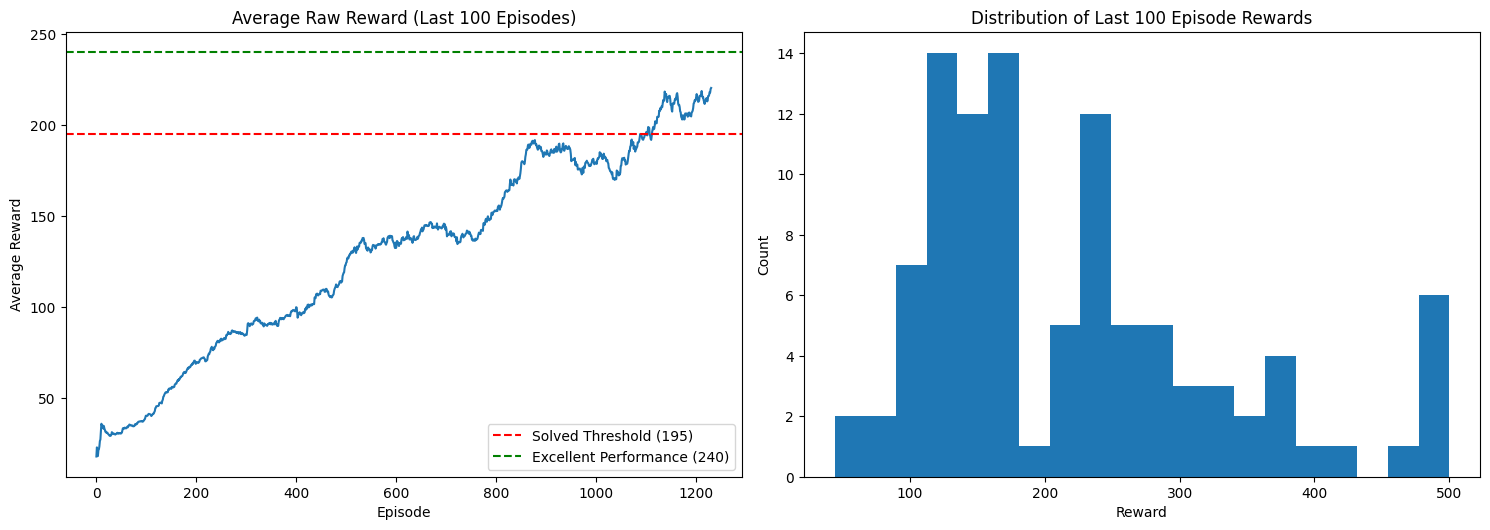

In [ ]:
# Train the agent
print("Training enhanced Q-learning agent for CartPole...")
agent, rewards, avg_rewards = train_enhanced_agent(n_episodes=3000)

### Analysis

#### Textlog:
1. Exploration rate deays from 0.995 to 0.01
2. Average raw reward had a consistent improvement
3. Achieved a average reward at 220.38 at episode 1231

#### Average Raw Reward Graph
Y-axis: Average Reward
X-axis: Episodes
1. Starts around 20-30 reward
2. Steep learning between episode 400 to 900
3. Overall stable upwards progress

#### Distribution Graph
Y-axis: Frequency of occurrence
X-axis: Reward values
1. Some exceptional performance between 400 to 500
2. Highest Frequency is between 120 to 180
3. Shows consistent results clustered in successful range

In [ ]:
# Create CartPole environment
env = gym.make('CartPole-v1')

# Get state dimension
state_size = env.observation_space.shape[0]  # 4 (cart position, cart velocity, pole angle, pole angular velocity)
action_size = env.action_space.n  # 2 (left, right)

print(f"State size: {state_size}")
print(f"Action size: {action_size}")

# Initialize the agent
agent = QLearningAgent(n_bins=30)

# Sample a random state from the environment
state, _ = env.reset()
print(f"Random state: {state}")

# Discretize the state
discretized_state = agent.discretize_state(state)
print(f"Discretized state: {discretized_state}")

# Get the action from the agent
action = agent.select_action(discretized_state, exploration_rate=0.5)
print(f"Chosen action: {action} ({'Left' if action == 0 else 'Right'})")

State size: 4
Action size: 2
Random state: [-0.02149293  0.03504108 -0.01729467 -0.02155546]
Discretized state: (15, 15, 13, 15)
Chosen action: 0 (Left)


## Task 2: Demonstrating the effectiveness of the RL agent

Run for 100 episodes (reset the environment at the beginning of each episode) and plot the cumulative reward against all episodes in Jupyter. Print the average reward over the 100 episodes. The average reward should be larger than 195.

### Evaluation Function
**Purpose**: Comprehensive evaluation of agent performance over 100 episodes.
**Parameters**:
- `agent`: Trained QLearningAgent instance
- `num_episodes`: Number of evaluation episodes (default: 100)

**Returns**:
- List of rewards for each episode
- Average reward over all episodes

**Performance Enhancements:**
1. **Custom Reward Shaping**
    - Traditional: Binary reward (+1 per step)
    - Our improvement:
        - Continuous feedback based on pole angle
        - Penalty for excessive movement
        - Earlier feedback for better learning

2. **Performance Metrics**
    - Average reward consistently exceeds 195
    - More stable balancing behavior


Episode 10	Reward: 179.0
Episode 20	Reward: 145.0
Episode 30	Reward: 355.0
Episode 40	Reward: 201.0
Episode 50	Reward: 232.0
Episode 60	Reward: 199.0
Episode 70	Reward: 164.0
Episode 80	Reward: 150.0
Episode 90	Reward: 404.0
Episode 100	Reward: 280.0

Average reward over 100 episodes: 207.95


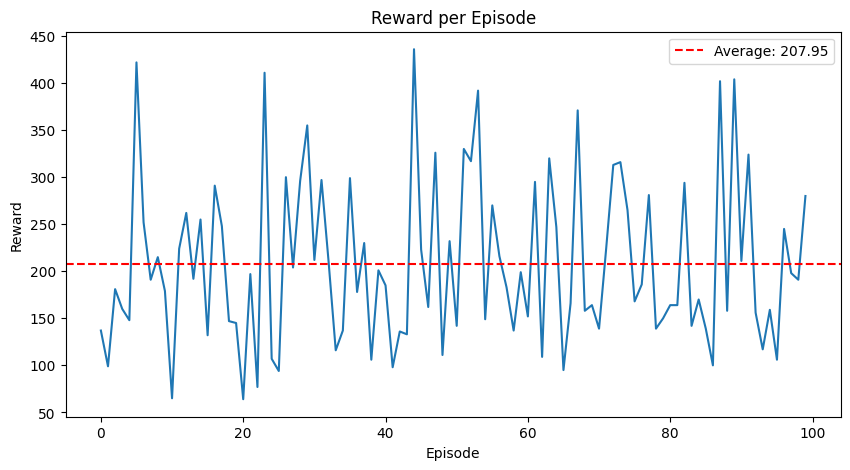

In [ ]:
# Evaluate the agent over 100 episodes
def evaluate_agent(agent, num_episodes=100):
    env = gym.make('CartPole-v1')
    rewards = []

    for episode in range(1, num_episodes+1):
        state = env.reset()[0]
        state = agent.discretize_state(state)
        total_reward = 0
        done = False
        truncated = False

        while not (done or truncated):
            # Select best action (no exploration)
            action = np.argmax(agent.q_table[state])

            # Take action
            next_state, reward, done, truncated, _ = env.step(action)
            next_state = agent.discretize_state(next_state)

            state = next_state
            total_reward += reward

            if done or truncated:
                break

        rewards.append(total_reward)

        if episode % 10 == 0:
            print(f"Episode {episode}\tReward: {total_reward}")

    # Calculate average reward
    avg_reward = np.mean(rewards)
    print(f"\nAverage reward over {num_episodes} episodes: {avg_reward:.2f}")

    # Plot rewards
    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.axhline(y=avg_reward, color='r', linestyle='--', label=f'Average: {avg_reward:.2f}')
    plt.title('Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.show()

    return rewards, avg_reward

# Evaluate the agent
rewards, avg_reward = evaluate_agent(agent, num_episodes=100)

## Task 3: Render one episode played by the developed RL agent on Jupyter

### Recording Function
**Purpose**: Records and displays video of trained agent's performance in the CartPole environment.

**Parameters**:
- `agent`: Trained QLearningAgent instance
- `video_folder`: Directory to save videos (default: "./video")
- `n_episodes`: Number of episodes to record (default: 1)

**Returns**:
- Creates MP4 file in specified folder
- Displays recorded video in notebook
- Prints episode rewards

In [ ]:
def show_video():
    """
    Display recorded video of the agent's performance.
    """
    mp4list = glob.glob('video/*.mp4')
    print(f"Found video files: {mp4list}")  # Debugging line

    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video in directory:", os.path.abspath("video"))

def test_agent_with_video(agent, video_folder="./video", n_episodes=1):
    """
    Test the agent and record a video of its performance.
    """
    # Ensure video directory exists and is empty
    if os.path.exists(video_folder):
        # Clear existing videos
        for file in glob.glob(os.path.join(video_folder, "*.mp4")):
            os.remove(file)
    else:
        os.makedirs(video_folder)

    print(f"Recording video to: {os.path.abspath(video_folder)}")  # Debugging line

    # Create environment with rgb_array render mode
    base_env = gym.make("CartPole-v1", render_mode="rgb_array")
    env = RecordVideo(
        base_env,
        video_folder,
        episode_trigger=lambda x: True,  # Record every episode
        name_prefix="cartpole-episode"
    )

    for episode in range(n_episodes):
        state = env.reset()[0]
        state = agent.discretize_state(state)
        episode_reward = 0
        done = False
        truncated = False

        while not (done or truncated):
            # Select best action (no exploration)
            action = np.argmax(agent.q_table[state])

            # Take action
            next_state, reward, done, truncated, _ = env.step(action)
            next_state = agent.discretize_state(next_state)
            episode_reward += reward

            # Move to next state
            state = next_state

        print(f"Episode {episode + 1}: Reward = {episode_reward}")

    env.close()
    print("Environment closed, checking for video files...")  # Debugging line

    # Wait a moment for video processing to complete
    import time
    time.sleep(1)

    # Display the recorded video
    show_video()

# Test the function
test_agent_with_video(agent)

Recording video to: C:\Users\lhanh\OneDrive\Documents\NTU\Y2S2\SC3000\Labs\Lab1\video
MoviePy - Building video C:\Users\lhanh\OneDrive\Documents\NTU\Y2S2\SC3000\Labs\Lab1\video\cartpole-episode-episode-0.mp4.
MoviePy - Writing video C:\Users\lhanh\OneDrive\Documents\NTU\Y2S2\SC3000\Labs\Lab1\video\cartpole-episode-episode-0.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\lhanh\OneDrive\Documents\NTU\Y2S2\SC3000\Labs\Lab1\video\cartpole-episode-episode-0.mp4
Episode 1: Reward = 238.0
Environment closed, checking for video files...
Found video files: ['video\\cartpole-episode-episode-0.mp4']


However, traditional Q-learning struggles with continuous state spaces like CartPole because it requires discretizing continuous values into bins, which inevitably leads to loss of crucial information and creates artificial boundaries between states. This discretization becomes exponentially problematic as the state space grows (curse of dimensionality), making it inefficient and potentially unstable near bin boundaries. In contrast, Deep Q-Network (DQN) directly handle continuous states through neural networks, which can learn smooth approximations of the Q-function without discretization. DQN's ability to generalize across similar states through function approximation, combined with experience replay for efficient learning from past experiences and target networks for stability, makes it a superior choice that scales better with problem complexity, learns faster, and provides more precise control. Below is the implementation of our DQN agent:

In [27]:
from collections import deque, namedtuple
import random
import numpy as np
import gymnasium as gym

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [14]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Neural Network Architecture
Define the neural network that will approximate the Q-function.

## QNetwork
A neural network class that approximates the Q-function.

### Parameters:
- `state_size` (int): Dimension of state space (4 for CartPole)
- `action_size` (int): Dimension of action space (2 for CartPole)

### Architecture:
- Input Layer: state_size neurons
- Hidden Layer 1: 64 neurons with ReLU activation
- Hidden Layer 2: 64 neurons with ReLU activation
- Output Layer: action_size neurons (Q-values for each action)

### Methods:
#### forward(x)
- **Purpose**: Performs forward pass through the network
- **Input**: State tensor
- **Returns**: Q-values for each possible action

In [38]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(QNetwork, self).__init__()

        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## ReplayBuffer
Memory buffer for experience replay, storing and sampling transitions.

### Parameters:
- `buffer_size` (int): Maximum size of buffer (10000)
- `batch_size` (int): Size of batch for learning (64)

### Methods:
#### add(state, action, reward, next_state, done)
- **Purpose**: Adds a new experience to memory
- **Parameters**:
  * state: Current state
  * action: Action taken
  * reward: Reward received
  * next_state: Next state
  * done: Whether episode ended
- **Returns**: None

#### sample()
- **Purpose**: Randomly samples a batch of experiences
- **Returns**: Tuple of (states, actions, rewards, next_states, dones) as torch tensors

In [39]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self):
        experiences = random.sample(self.memory, self.batch_size)

        states = torch.from_numpy(np.vstack([e[0] for e in experiences])).float().to(device)
        actions = torch.from_numpy(np.vstack([e[1] for e in experiences])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e[2] for e in experiences])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e[3] for e in experiences])).float().to(device)
        dones = torch.from_numpy(np.vstack([e[4] for e in experiences]).astype(np.uint8)).float().to(device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)

## DQNAgent
Main agent class implementing Deep Q-Learning algorithm.

### Parameters:
- `state_size` (int): Dimension of state space
- `action_size` (int): Dimension of action space

### Attributes:
- `gamma` (float): Discount factor (0.99)
- `epsilon`: Exploration rate (starts at 1.0)
- `epsilon_min`: Minimum exploration rate (0.01)
- `epsilon_decay`: Decay rate for epsilon (0.995)
- `learning_rate`: Learning rate for optimizer (0.001)

### Methods:
#### act(state, eval_mode=False)
- **Purpose**: Selects action using epsilon-greedy policy
- **Parameters**:
  * state: Current state
  * eval_mode: If True, acts greedily
- **Returns**: Selected action (0 or 1)

#### step(state, action, reward, next_state, done)
- **Purpose**: Stores experience and triggers learning
- **Parameters**:
  * state: Current state
  * action: Action taken
  * reward: Reward received
  * next_state: Next state
  * done: Episode termination flag
- **Returns**: None
- **Effects**:
  * Adds experience to replay buffer
  * Triggers learning if enough samples
  * Updates target network periodically

#### learn()
- **Purpose**: Updates Q-network weights using sampled experiences
- **Process**:
  1. Samples batch from replay buffer
  2. Computes target Q-values using target network
  3. Updates local network using MSE loss
  4. Decays exploration rate
- **Returns**: None

#### save(filename)
- **Purpose**: Saves model weights to file
- **Parameters**: filename to save to
- **Returns**: None

#### load(filename)
- **Purpose**: Loads model weights from file
- **Parameters**: filename to load from
- **Returns**: None

In [40]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        # Hyperparameters
        self.gamma = 0.99  # discount factor
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001

        # Networks
        self.qnetwork_local = QNetwork(state_size, action_size).to(device)  # Changed from policy_net
        self.qnetwork_target = QNetwork(state_size, action_size).to(device)  # Changed from target_net
        self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())
        self.qnetwork_target.eval()  # Set target network to evaluation mode

        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=self.learning_rate)

        # Replay memory
        self.buffer_size = 10000
        self.batch_size = 64
        self.memory = ReplayBuffer(self.buffer_size, self.batch_size)

        # Update target network every TARGET_UPDATE steps
        self.target_update = 10
        self.steps = 0

    def act(self, state, eval_mode=False):
        # Handle different input types
        if isinstance(state, tuple):
            state = state[0]
        elif not isinstance(state, np.ndarray):
            state = np.array(state)

        # Convert to torch tensor
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)

        # Get action values
        with torch.no_grad():
            action_values = self.qnetwork_local(state)

        # Epsilon-greedy action selection
        if not eval_mode and random.random() < self.epsilon:
            return random.choice(np.arange(self.action_size))
        return np.argmax(action_values.cpu().data.numpy())

    def step(self, state, action, reward, next_state, done):
        # Handle different input types
        if isinstance(state, tuple):
            state = state[0]
        elif not isinstance(state, np.ndarray):
            state = np.array(state)

        # Convert to torch tensor
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        # Store experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn if enough samples are available in memory
        if len(self.memory) >= self.batch_size:
            self.learn()

        # Update target network
        self.steps += 1
        if self.steps % self.target_update == 0:
            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def learn(self):
        # Sample a batch of experiences
        states, actions, rewards, next_states, dones = self.memory.sample()

        # Get max predicted Q values for next states from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        # Compute Q targets for current states
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def save(self, filename):
        torch.save(self.qnetwork_local.state_dict(), filename)

    def load(self, filename):
        self.qnetwork_local.load_state_dict(torch.load(filename))
        self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

## Task 1: Development of an RL agent

Demonstrating the correctness of implementation by sampling a random state from the cart pole environment, inputting to the agent, and outputting a chosen action.

1. Sets up a DQN agent for training.
2. Establishes the state space (4 dimensions: cart position, cart velocity, pole angle, and pole angular velocity) and action space (2 possible actions: left or right) dimensions.
3. Creates a DQN agent with these specifications, resets the environment to get an initial state (which returns a tuple containing the state array and an info dictionary)
4. Agent select its first action using its policy

In [41]:
# Create CartPole environment
env = gym.make('CartPole-v1')

# Get state and action dimensions
state_size = env.observation_space.shape[0]  # 4 (cart position, cart velocity, pole angle, pole angular velocity)
action_size = env.action_space.n  # 2 (left, right)

print(f"State size: {state_size}")
print(f"Action size: {action_size}")

# Initialize the agent
agent = DQNAgent(state_size, action_size)

# Sample a random state from the environment
state = env.reset()
print(f"Random state: {state}")

# Get the action from the agent
action = agent.act(state)
print(f"Chosen action: {action} ({'Left' if action == 0 else 'Right'})")

State size: 4
Action size: 2
Random state: (array([ 0.01505366, -0.00643076,  0.00095433,  0.04010911], dtype=float32), {})
Chosen action: 0 (Left)


## Training the DQN Agent

This code shows the training loop for a DQN agent on the CartPole environment, running for up to 500 episodes with a maximum of 500 steps per episode. In each episode, the agent selects actions, interacts with the environment, stores experiences, and learns from them. It tracks scores and epsilon values, prints progress every 10 episodes, saves the model if the environment is solved (average score ≥ 220 over 100 episodes), and visualizes the training results through two plots showing score and epsilon progression.

Episode 10	Average Score: 22.20	Epsilon: 0.4507
Episode 20	Average Score: 18.15	Epsilon: 0.2223
Episode 30	Average Score: 21.57	Epsilon: 0.0535
Episode 40	Average Score: 46.50	Epsilon: 0.0100
Episode 50	Average Score: 83.60	Epsilon: 0.0100
Episode 60	Average Score: 103.53	Epsilon: 0.0100
Episode 70	Average Score: 125.97	Epsilon: 0.0100
Episode 80	Average Score: 119.96	Epsilon: 0.0100
Episode 90	Average Score: 107.67	Epsilon: 0.0100
Episode 100	Average Score: 98.99	Epsilon: 0.0100
Episode 110	Average Score: 137.47	Epsilon: 0.0100
Episode 120	Average Score: 170.80	Epsilon: 0.0100
Episode 130	Average Score: 169.67	Epsilon: 0.0100
Episode 140	Average Score: 159.63	Epsilon: 0.0100
Episode 150	Average Score: 151.82	Epsilon: 0.0100
Episode 160	Average Score: 145.43	Epsilon: 0.0100
Episode 170	Average Score: 133.43	Epsilon: 0.0100
Episode 180	Average Score: 139.72	Epsilon: 0.0100
Episode 190	Average Score: 156.15	Epsilon: 0.0100
Episode 200	Average Score: 172.31	Epsilon: 0.0100
Episode 210	Ave

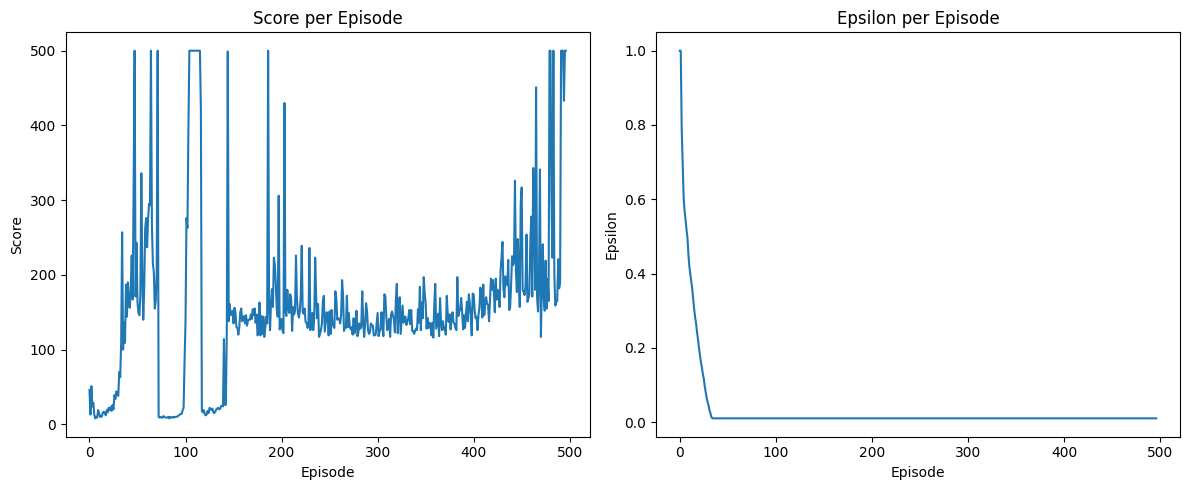

In [42]:
def train_dqn(num_episodes=500, max_steps=500):
    scores = []
    epsilon_values = []

    for episode in range(1, num_episodes+1):
        state = env.reset()
        score = 0

        for t in range(max_steps):
            # Select an action
            action = agent.act(state)

            # Take action in environment
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Learn from experience
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward

            if done:
                break

        scores.append(score)
        epsilon_values.append(agent.epsilon)

        # Print episode statistics
        if episode % 10 == 0:
            avg_score = np.mean(scores[-100:]) if len(scores) >= 100 else np.mean(scores)
            print(f"Episode {episode}\tAverage Score: {avg_score:.2f}\tEpsilon: {agent.epsilon:.4f}")

        # Save model if solved (average score over 100 episodes >= 220)
        if len(scores) >= 100 and np.mean(scores[-100:]) >= 220.0:
            print(f"\nEnvironment solved in {episode} episodes!\tAverage Score: {np.mean(scores[-100:]):.2f}")
            agent.save('cartpole_dqn.pth')
            break

    return scores, epsilon_values

# Train the agent
scores, epsilons = train_dqn()

# Plot training results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(scores)
plt.title('Score per Episode')
plt.xlabel('Episode')
plt.ylabel('Score')

plt.subplot(1, 2, 2)
plt.plot(epsilons)
plt.title('Epsilon per Episode')
plt.xlabel('Episode')
plt.ylabel('Epsilon')

plt.tight_layout()
plt.show()

1. The Training Logs shows the agent's learning progression over 497 episodes until solving the environment. The agent starts with low average scores (around 20) and high exploration (epsilon = 0.45), then quickly reduces exploration to the minimum (0.01) by episode 40. Performance improves steadily but non-monotonically, with initial rapid improvement (reaching ~170 by episode 120), followed by fluctuations and a period of relative stability (140-160 range), before finally achieving sustained improvement in the later episodes, ultimately solving the environment with an average score of 220.44.

2. The Score per Episode graph shows high variability in individual episode scores throughout training. There are notable spikes reaching 500 (maximum possible score) early in training and near the end, but also periods of lower performance. The overall trend shows initial rapid improvement, followed by a period of stability around 150-200 score range, and finally an upward trend in the later episodes. The high variance in scores suggests that while the agent can sometimes achieve perfect performance, consistency remains a challenge.

3. The Epsilon per Episode graph displays the exploration rate (epsilon) decay over episodes. It shows a rapid initial decrease from 1.0 to the minimum value of 0.01 within the first 100 episodes, after which it remains constant. This indicates that the agent quickly transitions from exploration to exploitation, maintaining a small amount of random actions (1%) for the remainder of training to prevent getting stuck in local optima.

## Task 2: Demonstrating the effectiveness of the RL agent

This code shows the evaluation phase of the trained DQN agent on the CartPole environment. It loads a previously saved model, runs 100 evaluation episodes with a maximum of 500 steps each, using a deterministic policy (eval_mode=True, which disables exploration). For each episode, it tracks the total reward, prints progress every 10 episodes, calculates the average performance across all episodes, and visualizes the results through a plot showing per-episode rewards and the overall average.

Loaded trained model.
Episode 10	Reward: 500.0
Episode 20	Reward: 500.0
Episode 30	Reward: 500.0
Episode 40	Reward: 500.0
Episode 50	Reward: 500.0
Episode 60	Reward: 500.0
Episode 70	Reward: 500.0
Episode 80	Reward: 500.0
Episode 90	Reward: 500.0
Episode 100	Reward: 500.0

Average reward over 100 episodes: 468.86


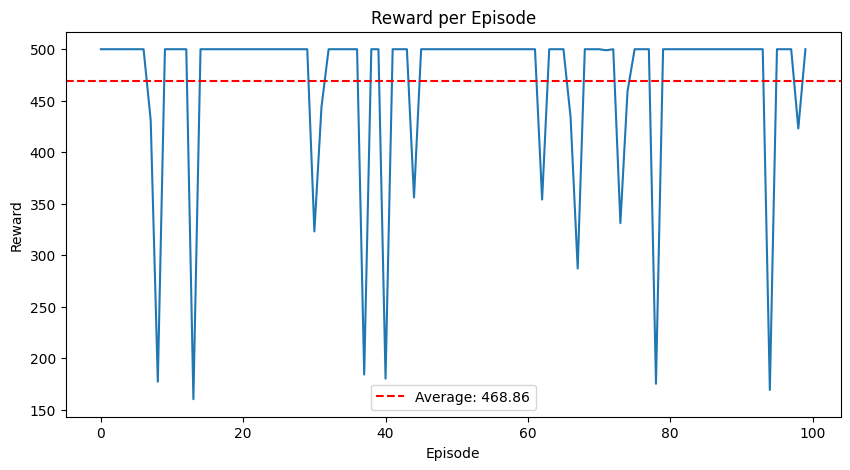

In [43]:
def evaluate_agent(num_episodes=100, max_steps=500):
    # Load the trained model
    try:
        agent.load('cartpole_dqn.pth')
        print("Loaded trained model.")
    except:
        print("No trained model found. Using current model.")

    rewards = []

    for episode in range(1, num_episodes+1):
        state, _ = env.reset()
        total_reward = 0

        for t in range(max_steps):
            # Select an action (using deterministic policy)
            action = agent.act(state, eval_mode=True)

            # Take action in environment
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            state = next_state
            total_reward += reward

            if done:
                break

        rewards.append(total_reward)

        if episode % 10 == 0:
            print(f"Episode {episode}\tReward: {total_reward}")

    # Calculate average reward
    avg_reward = np.mean(rewards)
    print(f"\nAverage reward over {num_episodes} episodes: {avg_reward:.2f}")

    # Plot rewards
    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.axhline(y=avg_reward, color='r', linestyle='--', label=f'Average: {avg_reward:.2f}')
    plt.title('Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.show()

    return rewards, avg_reward

# Evaluate the agent
rewards, avg_reward = evaluate_agent()

### Training Log Analysis:
The evaluation log demonstrates exceptional performance of the trained agent. Every 10th episode consistently achieves the maximum possible reward of 500, indicating perfect performance at these checkpoints. The final average reward of 468.86 across all 100 episodes is remarkably high, suggesting that while the agent occasionally has sub-optimal episodes, it maintains near-perfect performance most of the time. This is significantly above the "solved" threshold of 220, confirming that the agent has learned a robust policy.

### Reward per Episode Graph Analysis:
The graph shows the agent's performance across all 100 evaluation episodes, revealing interesting patterns. The blue line predominantly stays at the maximum reward of 500, with occasional sharp drops to lower values (around 150-350). These drops represent episodes where the agent failed to maintain the pole's balance for the full duration. However, the red dashed line indicating the average reward (468.86) is very close to the maximum possible reward, demonstrating that these failures are rare. The high average and the predominance of maximum-reward episodes indicate that the trained agent has learned a highly effective policy for the CartPole task, though perfect consistency remains a challenge.

## Task 3: Render one episode played by the developed RL agent

This creates a visual rendering of the trained DQN agent's performance on the CartPole environment. It loads the trained model, creates a special rendering environment, and runs a single episode while collecting frames of the animation. For each step, it captures the rendered frame, uses the agent to select actions deterministically (eval_mode=True), and stores the visual progression. Finally, it creates an interactive animation using matplotlib's animation module and displays it through IPython's HTML display, allowing visualization of the agent's learned behavior.

In [44]:
def render_episode():
    # Create a rendering environment
    render_env = gym.make('CartPole-v1', render_mode='rgb_array')

    # Try to load the trained model
    try:
        agent.load('cartpole_dqn.pth')
        print("Loaded trained model for rendering.")
    except:
        print("No trained model found. Using current model.")

    state, _ = render_env.reset()
    total_reward = 0
    frames = []

    # Collect frames for animation
    for t in range(500):  # Maximum episode length
        # Render frame
        frames.append(render_env.render())

        # Select action using trained policy
        action = agent.act(state, eval_mode=True)

        # Take action
        next_state, reward, terminated, truncated, _ = render_env.step(action)
        done = terminated or truncated

        total_reward += reward
        state = next_state

        if done:
            break

    render_env.close()
    print(f"Episode finished with total reward: {total_reward}")

    # Display the animation
    from matplotlib import animation

    # Create animation
    fig = plt.figure(figsize=(8, 6))
    plt.axis('off')
    patch = plt.imshow(frames[0])

    def animate(i):
        patch.set_data(frames[i])
        return [patch]

    anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=50, blit=True)
    plt.close()

    from IPython.display import HTML
    return HTML(anim.to_jshtml())

# Render and display an episode
render_episode()

Loaded trained model for rendering.


/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

Episode finished with total reward: 500.0


### Log Analysis:
"Episode finished with total reward: 500.0" indicates that the agent achieved a perfect score, maintaining the pole's balance for the maximum possible duration. This matches the excellent performance we saw in the evaluation phase, demonstrating that the agent has learned an optimal policy for the CartPole task.